In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/DataHacks2021/

/content/drive/MyDrive/DataHacks2021


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
def transform_data(filename, num_days):
    input_data = pd.read_csv(filename, index_col=0)
    sp500 = input_data['SP500']
    lst = [[input_data.iloc[i-num_days:i].values,sp500[i]] for i in range(num_days,len(input_data))]
    final = [[[item for sublist in x[0] for item in sublist], x[1]] for x in lst]
    return final

In [5]:
class MyDataset(Dataset):
    def __init__(self, filename, num_days, debug=False):
        self.data = transform_data(filename, num_days)
        self.num_days = num_days
        if debug:
          self.data = self.data[:128]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        result = {}
        result["input"] = torch.tensor(self.data[index][0], dtype=torch.float32).reshape(num_days, -1).permute(1,0)
        result["output"] = torch.tensor(self.data[index][1], dtype=torch.float32)
        return result

In [6]:
class Net(nn.Module):
    def __init__(self, num_features, num_days):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv1d(num_features, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 256, 1)
        self.conv4 = torch.nn.Conv1d(256, 1024, 1)
        self.conv5 = torch.nn.Conv1d(1024, 128, 1)
        self.conv6 = torch.nn.Conv1d(128, 32, 1)
        self.conv7 = torch.nn.Conv1d(32, 8, 1)
        self.vertconv1 = torch.nn.Conv1d(num_days, 16, 1)
        self.vertconv2 = torch.nn.Conv1d(16, 1, 1)
        self.finalconv1 = torch.nn.Conv1d(8,16,1)
        self.finalconv2 = torch.nn.Conv1d(16,1,1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(1024)
        self.bn5 = nn.BatchNorm1d(128)
        self.bn6 = nn.BatchNorm1d(32)
        self.vertbn1 = nn.BatchNorm1d(16)
        self.finalbn = torch.nn.BatchNorm1d(16)
        self.drop = torch.nn.Dropout(0.2)

        for net in [
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5,
            self.conv6,
            self.conv7,
            self.vertconv1,
            self.vertconv2,
            self.finalconv1,
            self.finalconv2
        ]:
            torch.nn.init.xavier_uniform_(net.weight)

    def forward(self, inputs):
        x = inputs
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.drop(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.drop(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.drop(x)
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.drop(x)
        x = self.conv7(x)
        x = x.permute(0,2,1)
        x = F.relu(self.vertbn1(self.vertconv1(x)))
        x = self.vertconv2(x)
        x = x.permute(0,2,1)
        x = F.relu(self.finalbn(self.finalconv1(x)))
        x = self.finalconv2(x)
        return x.reshape(-1)

In [8]:
batch_size = 128
epochs = 120
lr = 1e-3  # scheduler will help
train_filename = "10_train.csv"
val_filename = "10_val.csv"
num_days = 7
num_features = len(transform_data(train_filename, num_days)[0][0])

model = Net(num_features, num_days).cuda()
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

train_data = MyDataset(train_filename, num_days)
train_loader = DataLoader(train_data, batch_size=batch_size)

val_data = MyDataset(val_filename, num_days)
val_loader = DataLoader(train_data, batch_size=batch_size)

loss = 0
for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_loss = 0
    model.train()
    for iteration, data in enumerate(train_loader):
        input = data["input"].cuda()
        gt = data["output"].cuda()
        optim.zero_grad()
        pred = model(input)
        loss = loss_fn(pred, gt)
        loss.backward()
        optim.step()
        train_loss += loss.item()
    model.eval()
    for iteration, data in enumerate(val_loader):
        input = data["input"].cuda()
        gt = data["output"].cuda()
        pred = model(input)
        loss = loss_fn(pred, gt)
        val_loss += loss.item()
    print("Epoch:{}, Training loss: {} Valiation loss: {}".format(epoch, train_loss / len(transform_data(train_filename, num_days)), val_loss / len(transform_data(val_filename, num_days))))

RuntimeError: ignored

In [ ]:
model.eval()
data = transform_data(filename, num_days)
scat = []
for i in range(len(data)):
    input = torch.tensor(data[i][0], dtype=torch.float32).reshape(1, num_days, -1).permute(0,2,1).cuda()
    gt = torch.tensor(data[i][1], dtype=torch.float32).cuda()
    pred = model(input)[0]
    scat.append([gt, pred])

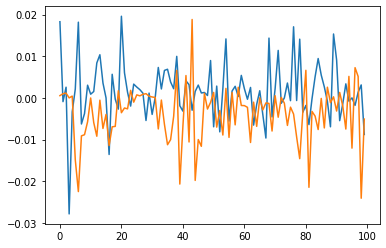

In [ ]:
plt.plot(scat[-100:])